In [1]:
from utils_v1 import *
from icecream import ic
import cv2
import gdal
# root_path = 'F:/Doctorado/Deforestation_SAR/Tensorflow2/INPE_Project/'
root_path = 'D:/jorg/phd/fifth_semester/deep_learning_course/handson_uncertainty/ISPRS/data/'

In [2]:
def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    #ic(data.shape)
    data = np.transpose(data, (1, 2, 0))
    return data

ic| im_train.shape: (2565, 1919, 4)
ic| im_test.shape: (2558, 2818, 4)
ic| im_train.shape: (2565, 1919, 4), im_train.dtype: dtype('float32')
ic| label_train_rgb.shape: (2565, 1919, 3)
    label_train_rgb.dtype: dtype('uint8')
ic| np.unique(label_train, return_counts = True): (array([0, 1, 2, 3, 4], dtype=int64),
                                                   array([1132698,  867583, 1255273, 1653521,   13160], dtype=int64))
ic| np.unique(label_test, return_counts = True): (array([0, 1, 2, 3, 4], dtype=int64),
                                                  array([1185224, 1302768, 2549104, 2144306,   27042], dtype=int64))
ic| label_train.shape: (2565, 1919)
ic| im_train.shape: (2565, 1919, 4)


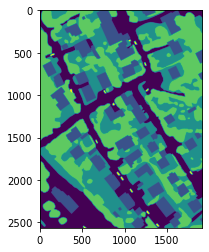

In [3]:
# Loading images
im_train = read_tiff(root_path+'train\im_train.tif')
dsm_train = gdal.Open(root_path+'train\dsm_train.tif').ReadAsArray()
im_train = np.concatenate((im_train, np.expand_dims(dsm_train, axis = -1)), axis = -1)
ic(im_train.shape)
del dsm_train
label_train_rgb = read_tiff(root_path+'train\label_train.tif')
im_test = read_tiff(root_path+'test\im_test.tif')
label_test_rgb = read_tiff(root_path+'test\label_test.tif')
dsm_test = gdal.Open(root_path+'test\dsm_test.tif').ReadAsArray()
im_test = np.concatenate((im_test, np.expand_dims(dsm_test, axis = -1)), axis = -1)
ic(im_test.shape)
del dsm_test

ic(im_train.shape, im_train.dtype)
ic(label_train_rgb.shape, label_train_rgb.dtype)


def mask_to_class(msk):

    msk = msk.astype(np.int64)
    new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)

    msk = msk // 255
    msk = msk * (1, 7, 49)
    msk = msk.sum(axis=2)

    new[msk == 1 + 7 + 49] = 0 # Street.
    new[msk ==         49] = 1 # Building.
    new[msk ==     7 + 49] = 2 # Grass.
    new[msk ==     7     ] = 3 # Tree.
    new[msk == 1 + 7     ] = 4 # Car.
    new[msk == 1         ] = 5 # Surfaces.
    new[msk == 0         ] = 6 # Boundaries.

    return new
    
            
label_train = mask_to_class(label_train_rgb)
label_test = mask_to_class(label_test_rgb)

del label_train_rgb, label_test_rgb

ic(np.unique(label_train, return_counts = True))
ic(np.unique(label_test, return_counts = True))

ic(label_train.shape)
ic(im_train.shape)
plt.figure()
plt.imshow(label_train)

In [4]:
from skimage.util import view_as_windows
channel_n = 4
ic(im_train.shape)
ic(label_test.shape)
patch_len = 128
im_train_patch = view_as_windows(im_train, (patch_len, patch_len, channel_n), step=patch_len//2)
im_test_patch = view_as_windows(im_test, (patch_len, patch_len, channel_n), step=patch_len)
label_train_patch = view_as_windows(label_train, (patch_len, patch_len), step=patch_len//2)
label_test_patch = view_as_windows(label_test, (patch_len, patch_len), step=patch_len)

#del im_train, im_test, label_train, label_test

im_train_patch = im_train_patch.reshape(-1, patch_len, patch_len, channel_n)
label_train_patch = label_train_patch.reshape(-1, patch_len, patch_len)
im_test_patch = im_test_patch.reshape(-1, patch_len, patch_len, channel_n)
label_test_patch = label_test_patch.reshape(-1, patch_len, patch_len)

ic(np.average(im_train_patch))
im_train_patch = im_train_patch.astype(np.float16) / 255.
im_test_patch = im_test_patch.astype(np.float16) / 255.
ic(np.average(im_train_patch))

ic(im_train_patch.shape)
ic(label_train_patch.shape)
ic(im_test_patch.shape)
ic(label_test_patch.shape)



ic| im_train.shape: (2565, 1919, 4)
ic| label_test.shape: (2558, 2818)
ic| np.average(im_train_patch): 140.2606
ic| np.average(im_train_patch): 0.5503
ic| im_train_patch.shape: (1092, 128, 128, 4)
ic| label_train_patch.shape: (1092, 128, 128)
ic| im_test_patch.shape: (418, 128, 128, 4)
ic| label_test_patch.shape: (418, 128, 128)


(418, 128, 128)

In [5]:
class_n = len(np.unique(label_train_patch))
ic(class_n)

def to_one_hot(label, class_n):
    b = np.zeros((label.size, class_n))
    b[np.arange(label.size), label] = 1
    return b

def patches_to_one_hot(label_patch, class_n):
    shape = label_patch.shape
    label_patch = to_one_hot(label_patch.flatten(), class_n)
    label_patch = label_patch.reshape((*shape, class_n))
    return label_patch

label_train_patch = patches_to_one_hot(label_train_patch, class_n)
label_test_patch = patches_to_one_hot(label_test_patch, class_n)
ic(label_train_patch.shape)



ic| class_n: 5
ic| label_train_patch.shape: (1092, 128, 128, 5)


(1092, 128, 128, 5)

In [6]:
'''
exp = 0
path_exp = root_path+'Experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet_dropout'
weights = [0.1, 0.9, 0]
'''
from sklearn.utils.class_weight import compute_class_weight
times = 1
method = 'resunet_dropout'
nb_filters = [16, 32, 64, 128, 256]

ic(np.unique(label_train_patch, return_counts = True))

class_weights = compute_class_weight('balanced', np.unique(label_train.flatten()), label_train.flatten()).astype(np.float16)
ic(class_weights)
class_n = len(np.unique(label_train))
ic(class_n)

ic| np.unique(label_train_patch, return_counts = True): (array([0., 1.]), array([71565312, 17891328], dtype=int64))
C:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 3 3 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
ic| class_weights: array([ 0.869,  1.135,  0.784,  0.595, 74.8  ], dtype=float16)
ic| class_n: 5


5

ic| np.unique(label_train_patch.argmax(axis=-1), return_counts=True): (array([0, 1, 2, 3, 4], dtype=int64),
                                                                       array([4093151, 3284982, 4582257, 5881724,   49214], dtype=int64))
ic| np.unique(label_train_patch.argmax(axis=-1)[idx], return_counts=True): (array([0, 2, 3], dtype=int64), array([ 3825,  1112, 11447], dtype=int64))


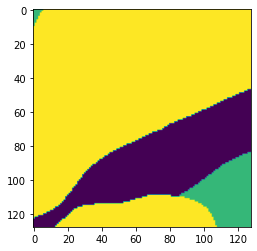

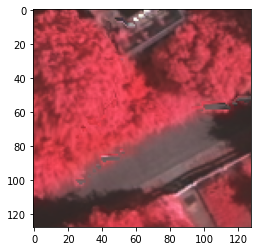

In [7]:
idx = 5
plt.imshow(label_train_patch.argmax(axis=-1)[idx])
ic(np.unique(label_train_patch.argmax(axis=-1), return_counts=True))
ic(np.unique(label_train_patch.argmax(axis=-1)[idx], return_counts=True))

plt.show()
plt.imshow(im_train_patch[idx,..., 0:3].astype(np.float32))
plt.show()

In [8]:
import pathlib
import pdb

metrics_all = []
training = True
path_models = 'model_best/'
pathlib.Path(path_models).mkdir(parents=True, exist_ok=True)


loss = weighted_categorical_crossentropy(class_weights)
input_shape = (patch_len, patch_len, channel_n)

if training == True:
    optimizer = Adam(lr = 1e-3 , beta_1=0.9)
#    model = build_resunet_dropout(input_shape, nb_filters, class_n)
    model = build_unet_dropout(input_shape, nb_filters, class_n, training=True)
#    model = build_unet(input_shape, nb_filters, class_n, training=True)
##    model = build_resunet(input_shape, nb_filters, class_n, training = True) # dropout
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(0)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)

    ic(im_train_patch.dtype, label_train_patch.dtype, class_weights.dtype)
    #pdb.set_trace()
    history = model.fit(im_train_patch, label_train_patch.astype(np.float16),
                            validation_split = 0.15,
                            batch_size=32,
                              epochs=100,
                              callbacks=[earlystop, checkpoint])


else:
    model = tf.keras.models.load_model(path_models+ '/' + method +'_'+str(0)+'.h5',
                                              custom_objects={"loss": loss})

C:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
ic| im_train_patch.dtype: dtype('float16')
    label_train_patch.dtype: dtype('float64')
    class_weights.dtype: dtype('float16')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 64) 2368        input_layer[0][0]                
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 128, 128, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
maxpooling1 (MaxPooling2D)      (None, 64, 64, 64)   0           conv1_2[0][0]                    
______________________________________________________________________________________________

Epoch 4/100
29/29 [==============================] - 7s 228ms/step - loss: 0.4722 - accuracy: 0.6035 - val_loss: 0.5704 - val_accuracy: 0.5064

Epoch 00004: val_loss did not improve from 0.53843
Epoch 5/100
29/29 [==============================] - 7s 228ms/step - loss: 0.4754 - accuracy: 0.6141 - val_loss: 0.5021 - val_accuracy: 0.6452

Epoch 00005: val_loss improved from 0.53843 to 0.50215, saving model to model_best\resunet_dropout_0.h5
Epoch 6/100
29/29 [==============================] - 7s 229ms/step - loss: 0.4374 - accuracy: 0.6557 - val_loss: 0.4732 - val_accuracy: 0.6549

Epoch 00006: val_loss improved from 0.50215 to 0.47320, saving model to model_best\resunet_dropout_0.h5
Epoch 7/100
29/29 [==============================] - 7s 226ms/step - loss: 0.4555 - accuracy: 0.6271 - val_loss: 0.4786 - val_accuracy: 0.6828

Epoch 00007: val_loss did not improve from 0.47320
Epoch 8/100
29/29 [==============================] - 6s 224ms/step - loss: 0.4182 - accuracy: 0.6545 - val_loss: 0

ic| im_test_patch.shape: (418, 128, 128, 4)
ic| im_test_patch[test_idx].shape: (128, 128, 4)
ic| np.expand_dims(im_test_patch[test_idx], axis=0).shape: (1, 128, 128, 4)
ic| im_test_patch.dtype: dtype('float16')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


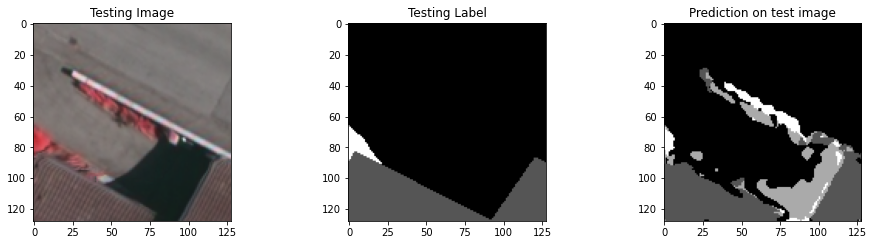

In [9]:
test_idx = 40
test_idx = 45
#test_idx = 57
#test_idx = 100
test_idx = 58
#test_idx = 59
#test_idx = 110
##test_idx = 250
test_idx = 300

test_img_input = im_test_patch[test_idx]

ic(im_test_patch.shape)
ic(im_test_patch[test_idx].shape)
ic(np.expand_dims(im_test_patch[test_idx], axis=0).shape)
ic(im_test_patch.dtype)
prediction = np.squeeze(model.predict(np.expand_dims(test_img_input, axis=0)))
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_input.astype(np.float32), cmap='gray')


plt.subplot(232)
plt.title('Testing Label')
plt.imshow(label_test_patch[test_idx].argmax(axis=-1).astype(np.float32), cmap='gray')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction.argmax(axis=-1).astype(np.float32), cmap='gray')

plt.show()


In [10]:
times = 100

In [ ]:
pred_probs = np.zeros((times, test_img_input.shape[0],test_img_input.shape[1], class_n), dtype = np.float32)
ic(pred_probs.shape)
ic(test_img_input.shape)
input_shape = (patch_len, patch_len, channel_n)

ic(input_shape)
##new_model = build_resunet(input_shape, nb_filters, class_n, training = True) # dropout

for tm in range(0,times):
  #print('time: ', tm)
##    new_model = build_resunet_dropout(input_shape, nb_filters, class_n, seed = tm)
    new_model = build_unet_dropout(input_shape, nb_filters, class_n, seed = tm, training = True)
#    model = build_unet(input_shape, nb_filters, class_n, training=True)
#    new_model = build_resunet(input_shape, nb_filters, class_n)

#    new_model.summary()
#    for l in range(1, len(model.layers)):
#        new_model.layers[l].set_weights(model.layers[l].get_weights())
        
    pred_prob = model.predict(np.expand_dims(test_img_input, 0))[0].astype(np.float32)
#  ic(pred_prob.shape)
    pred_probs[tm] = pred_prob


ic| pred_probs.shape: (100, 128, 128, 5)
ic| test_img_input.shape: (128, 128, 4)
ic| input_shape: (128, 128, 4)


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_mean(pred_probs):
    return np.mean(pred_probs, axis=0)

def get_uncertainty_std(pred_probs):
    return np.std(pred_probs, axis=0)

def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)


def show_im(im, ax, title = ""):
    im_plt = ax.imshow(im.astype(np.float32))
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 
    
    
uncertainty_std = get_uncertainty_std(pred_probs)
mean_prediction = get_mean(pred_probs)

ic(uncertainty_std.shape)


plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.title('Testing Image')
plt.imshow(test_img_input.astype(np.float32), cmap='gray')
plt.subplot(332)
plt.title('Testing Label')
plt.imshow(label_test_patch[test_idx].argmax(axis=-1).astype(np.float32), cmap='gray')

plt.subplot(333)
plt.title('Prediction on test image')
plt.imshow(prediction.argmax(axis=-1).astype(np.float32), cmap='gray')

plt.subplot(334)
plt.title('mean_prediction')
plt.imshow(mean_prediction.argmax(axis=-1).astype(np.float32), cmap='gray')

ax = plt.subplot(335)
show_im(uncertainty_std[...,0], ax, title = 'Uncertainty std class 0')
ax = plt.subplot(336)

show_im(uncertainty_std[...,1], ax, title = 'Uncertainty std class 1')

ax = plt.subplot(337)
show_im(uncertainty_std[...,2], ax, title = 'Uncertainty std class 2')

ax = plt.subplot(338)
show_im(uncertainty_std[...,3], ax, title = 'Uncertainty std class 3')

ax = plt.subplot(339)
show_im(uncertainty_std[...,4], ax, title = 'Uncertainty std class 4')


plt.show()


In [ ]:
# metrics


def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (255, 255, 5)
    ic(pred_mean.shape)
    pred_entropy = np.zeros(pred_mean.shape[0:2])
    ic(pred_entropy.shape)
    for k in range(pred_mean.shape[-1]):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k]) 
    pred_entropy = - pred_entropy / pred_mean.shape[-1]
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    # pred probs shape (n, 255, 255, class_n)
    sum_entropy = 0
    for i in range(pred_probs.shape[0]):
        for k in range(pred_probs.shape[-1]):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k])
        
    sum_entropy = - sum_entropy / (pred_probs.shape[0] * pred_probs.shape[-1])
        
    MI = H - sum_entropy
    ic(np.average(H))
    ic(np.average(sum_entropy))
    return MI

def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    for k in range(pred_prob.shape[-1]):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k]) 
    pred_entropy = - pred_entropy / pred_prob.shape[-1]
    return pred_entropy
    
    
pred_var = predictive_variance(pred_probs)
pred_entropy = predictive_entropy(pred_probs)
MI = mutual_information(pred_probs)



pred_entropy_single = single_experiment_entropy(pred_probs[0])

plt.figure(figsize=(16, 16))
subplot_id = 331
plt.subplot(subplot_id)
plt.title('Testing Image')
plt.imshow(test_img_input.astype(np.float32), cmap='gray')
plt.subplot(subplot_id + 1)
plt.title('Testing Label')
plt.imshow(label_test_patch[test_idx].argmax(axis=-1).astype(np.float32), cmap='gray')

# plt.subplot(333)
# plt.title('Prediction on test image')
# plt.imshow(prediction.argmax(axis=-1).astype(np.float32), cmap='gray')

plt.subplot(subplot_id + 2)
plt.title('mean_prediction')
plt.imshow(mean_prediction.argmax(axis=-1).astype(np.float32), cmap='gray')

ax = plt.subplot(subplot_id + 3)

show_im(pred_var, ax, title = 'Uncertainty predictive variance')
ax = plt.subplot(subplot_id + 4)

show_im(pred_entropy, ax, title = 'Uncertainty predictive entropy')

ax = plt.subplot(subplot_id + 5)

show_im(MI, ax, title = 'Uncertainty mutual information')

ax = plt.subplot(subplot_id + 6)

show_im(pred_entropy_single, ax, title = 'Uncertainty single entropy')

ax = plt.subplot(subplot_id + 7)

show_im(pred_entropy - pred_entropy_single, ax, title = 'Uncertainty difference')

plt.show()
plt.show()


In [ ]:
ic(im_test_patch.shape)
pred_test = model.predict(im_test_patch)
pred_test.shape

from sklearn import metrics


f1_score = metrics.f1_score(label_test_patch.argmax(axis=-1).flatten(), pred_test.argmax(axis=-1).flatten(), average = None)
ic(f1_score)
ic(np.average(f1_score))
#ic(mean_prediction.shape)
#ic(label_test_patch.shape)


In [ ]:
'''
import cv2
ood_im ='rand'
if ood_im == 'person':
    im = cv2.imread(root_path+ 'picturePerson.jpg')
    im = cv2.resize(im, (128, 128))
    plt.imshow(im)

    im_channel_aug = np.zeros((im.shape[0], im.shape[1], 14))
    im_channel_aug[..., :3] = im
    im_channel_aug[..., 3:6] = im
    im_channel_aug[..., 6:9] = im
    im_channel_aug[..., 9:12] = im
    im_channel_aug[..., 12:] = im[..., :1]
else:
    input_shape = (128, 128, 14)
    im_channel_aug = np.random.random(input_shape)
    plt.imshow(im_channel_aug[:,:,0]);
    
times = 5
prob_rec = np.zeros((im.shape[0],im.shape[1], times), dtype = np.float32)

input_shape = (128, 128, 14)
ic(input_shape)
#new_model = build_resunet_dropout(input_shape, nb_filters, number_class)
new_model = build_unet_dropout(input_shape, nb_filters, class_n)

ic(patch_size_rows)
for tm in range(0,times):
    print('time: ', tm)
    

#    new_model = build_resunet_dropout(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3, seed = tm)    


    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
        
    #ic(im.shape)
    #new_model.summary()
    
    predictions_ = new_model.predict(np.expand_dims(im_channel_aug, axis=0))
    prob_rec[:,:,tm] = predictions_[..., 1].astype(np.float32)
'''

In [ ]:
'''
mean_prob = np.mean(prob_rec, axis = -1)
ic(np.average(mean_prob))
std_prob = np.std(prob_rec, axis = -1)
ic(np.average(std_prob))

ic(std_prob.shape)
np.save(path_maps+'/prob_mean.npy', mean_prob)

fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')

fig2 = plt.figure(figsize=(10,10))
plt.imshow(std_prob, cmap = 'jet')

'''

In [ ]:
'''
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1

# Number of thresholds to generate the curve    
Npoints = 6
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 69)
np.save(path_exp+'/acc_metrics.npy',metrics_)
'''

In [ ]:
'''
# Complete NaN values
metrics_copy = metrics_.copy()
metrics_copy = complete_nan_values(metrics_copy)
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]

# Generating mAP curve
mAP = Area_under_the_curve(Recall, Precision)
print('mAP: ', mAP)

plt.close('all')
plt.plot(Recall, Precision)
plt.grid()
'''